## Comparison between precipitation features and convective cells based on CTT 

**Notes:** 
    
Precipitation 
- plot with contribution of total precip > 3000m, from heavy precip > 5mm which are non contiguous/isolated (local precip), contiguous in space (at least 10 pixels), contiguous in space and time (10 pixels and 3 hours), incorporated in precipitating cloud system (combined tracking) 


Method section 
- plot which shows lifetime, nr of tracks and area for each of the 3 methods (precip, tbb, tbb_cold_core, combined)



In [3]:
# read in cells from precip tracking 
import numpy as np 
import pandas as pd 

# read in precip tracks 
precipfile = '/media/juli/Elements/gpm_v06/Save/Tracks_GPM_2000_2019_5mm.h5'
preciptracks= pd.read_hdf(precipfile, 'table')
preciptracks.timestr = pd.to_datetime(preciptracks.timestr)

# read in CTT tracks heavy rain core 
tbb = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/Tracks_tbb_2004_heavyraincorefiltered.h5'
tbbtracks= pd.read_hdf(tbb, 'table')
tbbtracks.timestr = pd.to_datetime(tbbtracks.timestr)


# read in CTT tracks cold core 
tbb = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/Tracks_tbb_2004_cold_core.h5'
tbbcold= pd.read_hdf(tbb, 'table')
tbbcold.timestr = pd.to_datetime(tbbcold.timestr)


# read in CTT tracks only tbb 
tbb = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/Tracks_2004.h5'
tbb= pd.read_hdf(tbb, 'table')
tbb.timestr = pd.to_datetime(tbb.timestr)


In [36]:
# get only summer cells 
tracks = preciptracks
for i in np.unique(tracks.time.values):
    if i.month not in [6,7, 8]:
        tracks.drop(tracks.loc[tracks['time']== i].index, inplace=True)

In [37]:
summertracks = tracks 
summertracks.to_hdf('/media/juli/Elements/gpm_v06/Save/Tracks_GPM_2000_2019_JJA.h5', 'table')
n= np.unique(summertracks.timestr).shape[0]
n / (48*90*20) * 100

40.58796296296296

In [149]:
# function to get seasonal curve of tracks

def get_seasonal_cycle(preciptracks):
    preciptracks['month']= preciptracks.timestr.dt.month

    seasonal=[]
    for m in np.arange(1,13):
        monthly_count = preciptracks[preciptracks.month== m].shape[0]
        seasonal.append(monthly_count)
        
    return seasonal

## Plot seasonal cycle and diurnal cycle 

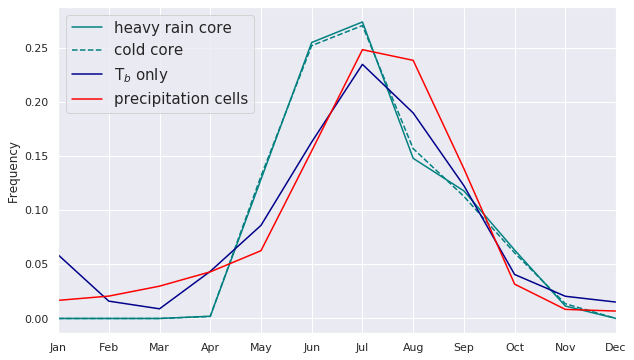

In [258]:
seasonal_precip = get_seasonal_cycle(preciptracks)
seasonal_tbb_rain= get_seasonal_cycle(tbbtracks)
seasonal_tbb_cold= get_seasonal_cycle(tbbcold)
seasonal_tbb= get_seasonal_cycle(tbb)


import seaborn as sns 
sns.set()


plt.figure(figsize=(10,6))

plt.plot(seasonal_tbb_rain/ np.nansum(seasonal_tbb_rain), label = 'heavy rain core ', color= 'teal')
plt.plot(seasonal_tbb_cold/ np.nansum(seasonal_tbb_cold), label = 'cold core', color= 'teal', linestyle='--')
plt.plot(seasonal_tbb/ np.nansum(seasonal_tbb), label = 'T$_b$ only', color= 'darkblue')
plt.plot(seasonal_precip/np.nansum(seasonal_precip), label = 'precipitation cells', color= 'red')
plt.legend(fontsize= 15)

plt.xticks(np.arange(0,12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec'])
plt.xlim(0,11)
plt.ylabel('Frequency')
plt.savefig('/media/juli/Data/projects/mcs_tracking/CTT/analysis/seasonal_cycle_tracking_methods.png')
plt.show()

##  lifetime histogram 

In [6]:
def get_lifetime(tracks):
    lt= []
    for cell in np.unique(tracks.cell.values):
        hours= tracks[tracks.cell== cell].shape[0] * 0.5
        lt.append(hours)
    lt = np.array(lt)
    lt= np.histogram(lt, bins=(3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20))
    print('lifetime histo calculated.')
    return lt

In [7]:
lt_precip = get_lifetime(preciptracks)
lt_tbb_rain= get_lifetime(tbbtracks)
lt_tbb_cold= get_lifetime(tbbcold)
lt_tbb= get_lifetime(tbb)

lifetime histo calculated.
lifetime histo calculated.
lifetime histo calculated.
lifetime histo calculated.


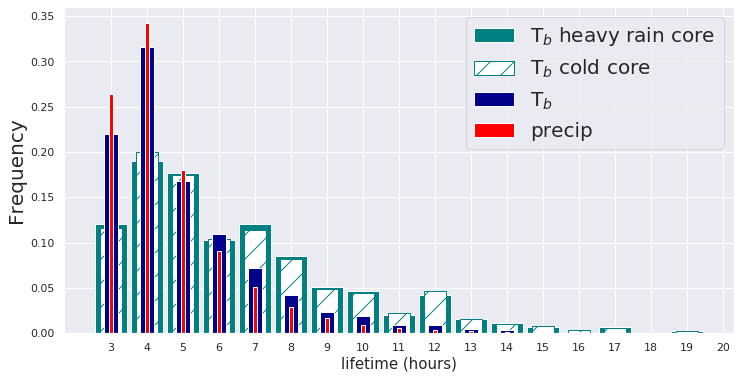

In [12]:
bins = lt_precip[1]
import matplotlib.pyplot as plt

import seaborn as sns 
sns.set()




plt.figure(figsize=(12,6))


plt.bar(bins[:-1] , lt_tbb_rain[0]/ np.nansum(lt_tbb_rain[0]), label= 'T$_b$ heavy rain core', width=0.9,color= 'teal')

plt.bar(bins[:-1] , lt_tbb_cold[0]/ np.nansum(lt_tbb_cold[0]), label = 'T$_b$ cold core', width = 0.6,hatch= '/', edgecolor= 'teal', color= 'white')


plt.bar(bins[:-1] , lt_tbb[0]/ np.nansum(lt_tbb[0]), label= 'T$_b$', width= 0.4, color= 'darkblue')

plt.bar(bins[:-1] , lt_precip[0]/ np.nansum(lt_precip[0]), label='precip', width = 0.1, color= 'red')

plt.legend(fontsize= 20)

plt.xticks(bins[:])
plt.xlabel('lifetime (hours)', fontsize= 15)
plt.ylabel('Frequency', fontsize= 20)

plt.savefig('/media/juli/Data/projects/mcs_tracking/CTT/analysis/lifetime_tracking_methods.png')
plt.show()

In [4]:
# calculate propagation speed (tobac can be used)
import tobac

preciptracks = tobac.calculate_velocity(preciptracks, method_distance=None)

In [ ]:
# calculate area 

In [324]:
# divide into north-moving, east-moving and other 

def propagation_dir(tracks):
    pd.options.mode.chained_assignment = None 
    
    tracks['dir'] = 0 
    for c in np.unique(tracks.cell.values):
        cell= tracks[tracks.cell == c]

        west_east= cell.longitude.values[-1] - cell.longitude.values[0]
        north_south = cell.latitude.values[-1] - cell.latitude.values[0]

        if north_south > west_east:
            if np.nanmean(cell.latitude.values[0:2]) < np.nanmean(cell.latitude.values[-3:-1]):
                tracks['dir'][tracks.cell == c] =  'N'
            elif np.nanmean(cell.latitude.values[0:2]) > np.nanmean(cell.latitude.values[-3:-1]):
                tracks['dir'][tracks.cell == c] =  'S'
                
        elif north_south < west_east:
            if np.nanmean(cell.longitude.values[0:2]) < np.nanmean(cell.longitude.values[-3:-1]):
                tracks['dir'][tracks.cell == c] =  'E'
            elif np.nanmean(cell.longitude.values[0:2]) > np.nanmean(cell.longitude.values[-3:-1]):
                tracks['dir'][tracks.cell == c] =  'W'
    return tracks 

In [327]:
print(tbb[tbb.dir=='N'].shape,tbb[tbb.dir=='E'].shape, tbb[tbb.dir=='W'].shape, tbb[tbb.dir=='S'].shape)

(16616, 16) (26189, 16) (6152, 16) (9635, 16)


In [325]:
#  separate tracks based on propagation direction, thresholds for intensity, and TP domain vs. surrounding 
tbb = propagation_dir(tbb)

## TP flag 

In [328]:

def tp_flag(tracks):
    removed = 0 
    tracks['tp_flag'] = 0 

    # loop through cells 
    for cell in np.unique(tracks.cell.values):
        subset = tracks[tracks.cell == cell]
        print('checking heavy rain cores for cell:', cell, subset.shape)
        tp_flag = 0 
        # loop through timesteps of features for specific cell 
        for idx in subset.idx.values: 
            # idx is the timestep index for respective timestep or mask file 

            # open corresponding precip and mask file 
            year = subset.time.values[0].year 
            month = subset.time.values[0].month
            if len(str(month))== 1: 
                month= '0' + str(month)

            # check whether segmented feature is in area above 3000 m 
            maskfile = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/Mask_Segmentation_'+str(year) + str(month) + '.nc'
            mask = xr.open_dataarray(maskfile)
            mask= mask[:,1:,1:].T

            # get right timestep frames 
            seg= mask[:,:,idx]

            # get feature ID for frame 
            featureid= subset.feature[subset.idx== idx].values[0]
        
            # create mask as coordinates 
            seg_mask = seg.where(seg == featureid)
            seg_mask.coords['mask'] = (('lon', 'lat'), seg_mask)
            # apply mask on precip data to extract precip values for feature in cell 
            elevation_values = dem_mask.where(seg_mask.coords['mask'].values > 1)
            arr= elevation_values.values.flatten()
            values = arr[~np.isnan(arr)]
            mountain_features = values[values >=3000].shape[0]

            if mountain_features >= 10: 
                tp_flag += mountain_features
                # percentage of area which lies within TP boundary 
                percentage= tp_flag / tracks[tracks.feature == featureid].ncells.values[0]
                tracks['tp_flag'][tracks.feature == featureid] =  percentage

        if tp_flag ==  0: 
            # remove corresponding cell from track dataframe 
            tracks = tracks.drop(tracks[tracks.cell == cell].index)
            print(cell, ' removed, because it is outside of the 3000 m boundary.')
            removed += 1 
        else:
            print('cell is over TP:  ', cell)

    return tracks 

In [ ]:
# save new track data frame 
tracks.to_hdf(os.path.join(savedir,'Tracks_TPflag.h5'),'table')    

## Contribution to precip 

## Basic characterics 

In [ ]:
# density plot of spatial distribution 

In [ ]:
# density intitiation vs. dissipation 

## What is the maximum elevation for cells ? 

## Trends of convective cells in TP region 